# DACON 펭귄 몸무게 예측 경진대회

- Species, Sex, Island 별 펭귄의 특징을 나누어 결측치 채움
- 이상치 탐색하여 drop
- OLS 회귀 사용
- imbalaced data oversampling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('./_data/train.csv', index_col=0)
test = pd.read_csv('./_data/test.csv', index_col=0)

# 데이터 확인

In [13]:
# from dataprep.eda import create_report
# report = create_report(train)
# report.save('dataprep_reoprt')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              114 non-null    object 
 1   Island               114 non-null    object 
 2   Clutch Completion    114 non-null    object 
 3   Culmen Length (mm)   114 non-null    float64
 4   Culmen Depth (mm)    114 non-null    float64
 5   Flipper Length (mm)  114 non-null    int64  
 6   Sex                  111 non-null    object 
 7   Delta 15 N (o/oo)    111 non-null    float64
 8   Delta 13 C (o/oo)    111 non-null    float64
 9   Body Mass (g)        114 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 9.8+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 227
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              228 non-null    object 
 1   Island               228 non-null    object 
 2   Clutch Completion    228 non-null    object 
 3   Culmen Length (mm)   228 non-null    float64
 4   Culmen Depth (mm)    228 non-null    float64
 5   Flipper Length (mm)  228 non-null    float64
 6   Sex                  222 non-null    object 
 7   Delta 15 N (o/oo)    219 non-null    float64
 8   Delta 13 C (o/oo)    220 non-null    float64
dtypes: float64(5), object(4)
memory usage: 17.8+ KB


* Sex, Delta 15 N (o/oo), Body Mass (g) 에 null값 존재

# 열이름 변경

In [8]:
def convert_columns_name(df):
    df.columns = df.columns.str.replace(' ', '')
    df.columns = df.columns.str.replace('(mm)', '')
    df.columns = df.columns.str.replace('(g)', '')
    df.columns = df.columns.str.replace('(o/oo)', '')
    df.columns = df.columns.str.replace('(', '')
    df.columns = df.columns.str.replace(')', '')
    return df

In [10]:
train = convert_columns_name(train)
test = convert_columns_name(test)
print(train.columns)
print(test.columns)

Index(['Species', 'Island', 'ClutchCompletion', 'CulmenLenth', 'CulmenDepth',
       'FlipperLenth', 'Sex', 'Delta15N', 'Delta13C', 'BodyMass'],
      dtype='object')
Index(['Species', 'Island', 'ClutchCompletion', 'CulmenLenth', 'CulmenDepth',
       'FlipperLenth', 'Sex', 'Delta15N', 'Delta13C'],
      dtype='object')


# 결측치 채우기
## Delta15N, Delta13C는 평균값으로 채우기

In [11]:
train[train.isna().sum(axis=1) > 0]

,Species,Island,ClutchCompletion,CulmenLenth,CulmenDepth,FlipperLenth,Sex,Delta15N,Delta13C,BodyMass
id,,,,,,,,,,
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


### Species 종 이름을 숫자로 변경

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
species = le.fit_transform(train['Species'].values)
train['Species'] = species
train['Species']

id
0      2
1      1
2      2
3      2
4      2
      ..
109    0
110    0
111    0
112    1
113    2
Name: Species, Length: 114, dtype: int32

In [13]:
species = le.fit_transform(test['Species'].values)
test.Species = species

In [14]:
train[(train['Species']==0) & (train['Island']=='Torgersen')]

,Species,Island,ClutchCompletion,CulmenLenth,CulmenDepth,FlipperLenth,Sex,Delta15N,Delta13C,BodyMass
id,,,,,,,,,,
6,0,Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,0,Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
20,0,Torgersen,Yes,38.8,17.6,191,FEMALE,8.88098,-25.89741,3275
28,0,Torgersen,Yes,37.3,20.5,199,MALE,9.49645,-26.36678,3775
29,0,Torgersen,Yes,39.3,20.6,190,MALE,8.66496,-25.29805,3650
38,0,Torgersen,Yes,33.5,19.0,190,FEMALE,7.88863,-26.63085,3600
50,0,Torgersen,Yes,45.8,18.9,197,MALE,8.18658,-26.45978,4150
52,0,Torgersen,Yes,42.9,17.6,196,MALE,8.63259,-26.23027,4700
58,0,Torgersen,Yes,37.2,19.4,184,MALE,8.35540,-26.44787,3900


### Delta15N열에 결측치가 존재하는 행 확인

In [12]:
# na_Delta15N = train[train['Delta15N'].isna()==True].index
# na_Delta15N

### Delta15N과 Delta13C의 결측치는 해당 펭귄의 종& 발견된 섬이름과 일치하는 펭귄들의 평균값으로 채움

In [14]:
# for i in na_Delta15N:
#     imputation = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island']), 'Delta15N'].mean()
#     train.loc[i, 'Delta15N'] = imputation
#     print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')

### Delta13N열에 결측치가 존재하는 행 확인

In [15]:
# na_Delta13C = train[train['Delta13C'].isna()==True].index
# na_Delta13C

In [16]:
# for i in na_Delta13C:
#     imputation = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island']), 'Delta13C'].mean()
#     train.loc[i, 'Delta13C'] = imputation
#     print(f'id {i}의 결측치를 {imputation}로 채웁니다.')

## Sex의 Null값 변경

### 결측치가 존재하는 행 확인

In [17]:
# na_Sex = train[train['Sex'].isna()==True].index
# na_Sex

1. 현재 데이터의 min, max값에 벗어나지 않게
2. MIN, MAX 값이내의 데이터라면, 평균값을 비교해서 더 가까운 쪽의 성별로 채움

In [18]:
# for i in na_Sex:
#     maxFlipperLenth_F = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='FEMALE'), 'FlipperLenth'].max()
#     minFlipperLenth_M = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='MALE'), 'FlipperLenth'].min()
    
#     maxCulmenLenth_F = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='FEMALE'), 'CulmenLenth'].max()
#     minCulmenLenth_M = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='MALE'), 'CulmenLenth'].min()
    
#     flipperLen = train.iloc[i].FlipperLenth
#     culmenLen = train.iloc[i].CulmenLenth
    
#     if (flipperLen<minFlipperLenth_M) or (culmenLen<minCulmenLenth_M):
#         imputation = 'FEMALE'
#         train.loc[i,"Sex"] = imputation
#         print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')
#     elif flipperLen> maxFlipperLenth_F or culmenLen> maxCulmenLenth_F:
#         imputation = 'MALE'
#         train.loc[i,"Sex"] = imputation
#         print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')
        
#     else:
#         meanFlipperLenth_F = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='FEMALE'), 'FlipperLenth'].mean()
#         meanFlipperLenth_M = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='MALE'), 'FlipperLenth'].mean()
#         meanCulmenLenth_F = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='FEMALE'), 'CulmenLenth'].mean()
#         meanCulmenLenth_M = train.loc[(train['Species']==train.loc[i,'Species'])&(train['Island']==train.loc[i,'Island'])&(train['Sex']=='MALE'), 'CulmenLenth'].mean()
        
#         if (meanFlipperLenth_F-flipperLen)**2+(meanCulmenLenth_F-culmenLen)**2 > (meanFlipperLenth_M-flipperLen)**2+(meanCulmenLenth_M-culmenLen)**2:
#             imputation = 'MALE'
#         else:
#             imputation = 'FEMALE'
            
#         train.loc[i,"Sex"] = imputation
#         print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')

## 결측치 채우기: 함수로 변경

In [15]:

def imputation(train_df, impu_df):
    na_Delta15N = impu_df[impu_df['Delta15N'].isna()==True].index

    for i in na_Delta15N:
        imputation = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island']), 'Delta15N'].mean()
        impu_df.loc[i, 'Delta15N'] = imputation
        print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')
    
    na_Delta13C = impu_df[impu_df['Delta13C'].isna()==True].index
    for i in na_Delta13C:
        imputation = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island']), 'Delta13C'].mean()
        impu_df.loc[i, 'Delta13C'] = imputation
        print(f'id {i}의 결측치를 {imputation}로 채웁니다.')
        
    na_Sex = impu_df[impu_df['Sex'].isna()==True].index
    
    for i in na_Sex:
        maxFlipperLenth_F = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='FEMALE'), 'FlipperLenth'].max()
        minFlipperLenth_M = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='MALE'), 'FlipperLenth'].min()

        maxCulmenLenth_F = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='FEMALE'), 'CulmenLenth'].max()
        minCulmenLenth_M = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='MALE'), 'CulmenLenth'].min()

        flipperLen = impu_df.FlipperLenth[i]
        culmenLen = impu_df.CulmenLenth[i]
    
        if (flipperLen<minFlipperLenth_M) or (culmenLen<minCulmenLenth_M):
            imputation = 'FEMALE'
            impu_df.loc[i,"Sex"] = imputation
            print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')
        elif flipperLen> maxFlipperLenth_F or culmenLen> maxCulmenLenth_F:
            imputation = 'MALE'
            impu_df.loc[i,"Sex"] = imputation
            print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')

        else:
            meanFlipperLenth_F = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='FEMALE'), 'FlipperLenth'].mean()
            meanFlipperLenth_M = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='MALE'), 'FlipperLenth'].mean()
            meanCulmenLenth_F = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='FEMALE'), 'CulmenLenth'].mean()
            meanCulmenLenth_M = train_df.loc[(train_df['Species']==impu_df.loc[i,'Species'])&(train_df['Island']==impu_df.loc[i,'Island'])&(train_df['Sex']=='MALE'), 'CulmenLenth'].mean()

            if (meanFlipperLenth_F-flipperLen)**2+(meanCulmenLenth_F-culmenLen)**2 > (meanFlipperLenth_M-flipperLen)**2+(meanCulmenLenth_M-culmenLen)**2:
                imputation = 'MALE'
            else:
                imputation = 'FEMALE'

            impu_df.loc[i,"Sex"] = imputation
            print(f'id: {i}의 결측치를 {imputation}로 채웁니다.')

In [16]:
imputation(train,train)
train.isna().sum()

id: 8의 결측치를 8.621242727272728로 채웁니다.
id: 18의 결측치를 8.987301111111112로 채웁니다.
id: 109의 결측치를 8.621242727272728로 채웁니다.
id 8의 결측치를 -26.017550909090904로 채웁니다.
id 18의 결측치를 -25.66734055555556로 채웁니다.
id 109의 결측치를 -26.017550909090904로 채웁니다.
id: 6의 결측치를 MALE로 채웁니다.
id: 8의 결측치를 FEMALE로 채웁니다.
id: 70의 결측치를 FEMALE로 채웁니다.


Species             0
Island              0
ClutchCompletion    0
CulmenLenth         0
CulmenDepth         0
FlipperLenth        0
Sex                 0
Delta15N            0
Delta13C            0
BodyMass            0
dtype: int64

### 테스트 데이터 결측치 채우기

In [17]:
test.isna().sum()

Species             0
Island              0
ClutchCompletion    0
CulmenLenth         0
CulmenDepth         0
FlipperLenth        0
Sex                 6
Delta15N            9
Delta13C            8
dtype: int64

In [18]:
imputation(train,test)
test.isna().sum()

id: 27의 결측치를 8.621242727272728로 채웁니다.
id: 75의 결측치를 9.4173136로 채웁니다.
id: 81의 결측치를 8.987301111111112로 채웁니다.
id: 106의 결측치를 8.276492083333332로 채웁니다.
id: 159의 결측치를 8.621242727272728로 채웁니다.
id: 175의 결측치를 8.987301111111112로 채웁니다.
id: 202의 결측치를 8.621242727272728로 채웁니다.
id: 205의 결측치를 8.621242727272728로 채웁니다.
id: 215의 결측치를 8.987301111111112로 채웁니다.
id 27의 결측치를 -26.017550909090907로 채웁니다.
id 81의 결측치를 -25.667340555555555로 채웁니다.
id 106의 결측치를 -26.269597291666667로 채웁니다.
id 159의 결측치를 -26.017550909090907로 채웁니다.
id 175의 결측치를 -25.667340555555555로 채웁니다.
id 202의 결측치를 -26.017550909090907로 채웁니다.
id 205의 결측치를 -26.017550909090907로 채웁니다.
id 215의 결측치를 -25.667340555555555로 채웁니다.
id: 46의 결측치를 FEMALE로 채웁니다.
id: 81의 결측치를 FEMALE로 채웁니다.
id: 98의 결측치를 FEMALE로 채웁니다.
id: 152의 결측치를 FEMALE로 채웁니다.
id: 205의 결측치를 FEMALE로 채웁니다.
id: 209의 결측치를 FEMALE로 채웁니다.


Species             0
Island              0
ClutchCompletion    0
CulmenLenth         0
CulmenDepth         0
FlipperLenth        0
Sex                 0
Delta15N            0
Delta13C            0
dtype: int64

## 시각화를 통해 Species 별 데이터 분포 확인

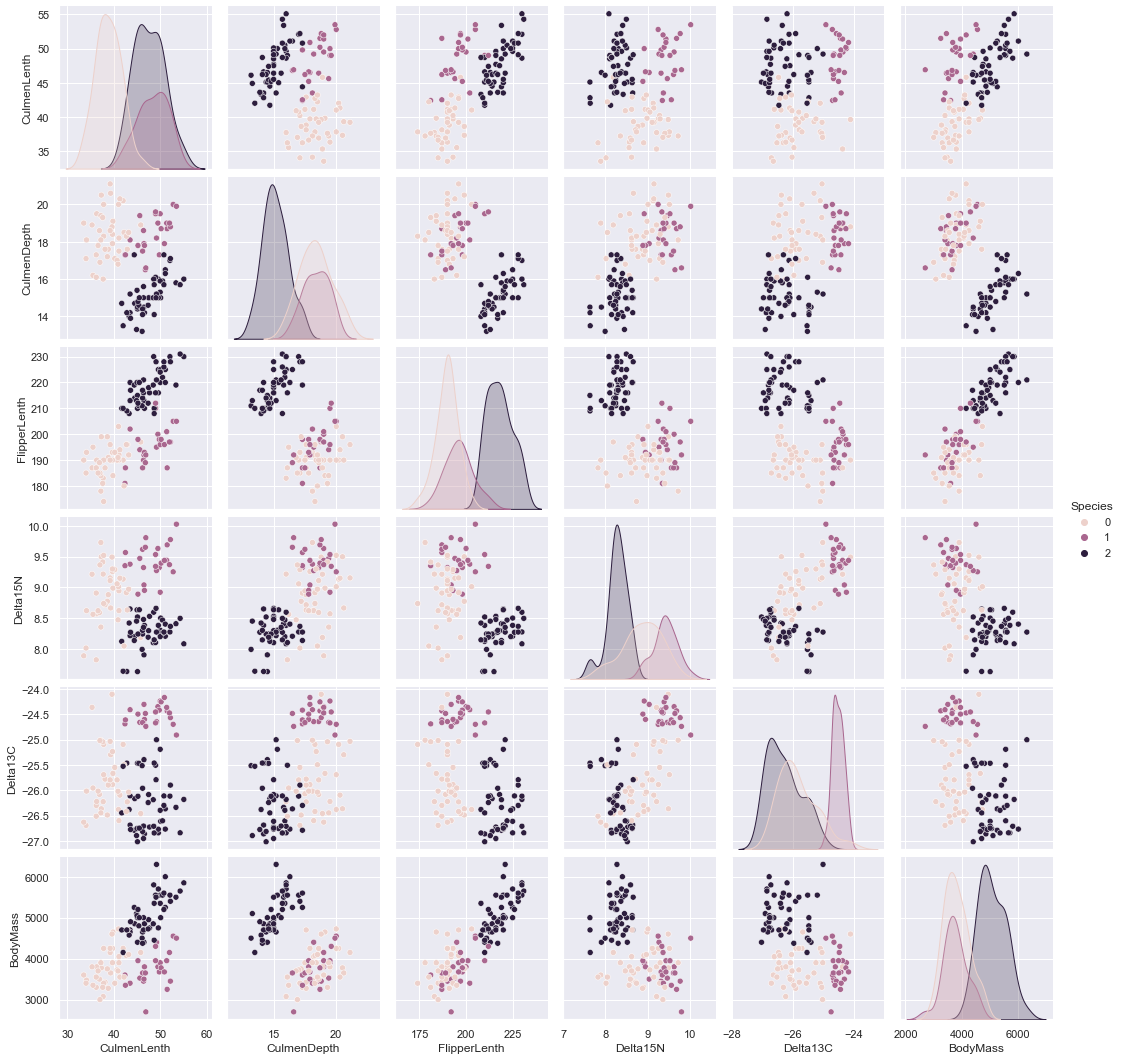

In [19]:
sns.pairplot(train,hue='Species')
plt.show()

### 모든 특징이 우상향 또는 우하향 하는 것으로 보임

In [20]:
from scipy import stats
from statsmodels.formula.api import ols, glm

## 수치형 데이터 표준화

In [21]:
numeric_cols = train.columns[3:-4].to_list() + train.columns[-3:-1].to_list()
numeric_cols

['CulmenLenth', 'CulmenDepth', 'FlipperLenth', 'Delta15N', 'Delta13C']

In [22]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train_std = stdsc.fit_transform(train.loc[:,numeric_cols])
test_std = stdsc.transform(test.loc[:,numeric_cols])

In [23]:
stdTrain = pd.DataFrame(train_std)
stdTrain.rename(columns = {x:y for x,y in enumerate(numeric_cols)}, inplace=True)
stdTrain = pd.concat([stdTrain, train['BodyMass']], axis=1)

In [24]:
stdTest= pd.DataFrame(test_std)
stdTest.rename(columns = {x:y for x,y in enumerate(numeric_cols)}, inplace=True)

## 범주형 데이터 더미로 변환

In [25]:
train_dummies = pd.get_dummies(train, columns=['Species','Island','ClutchCompletion','Sex'])
train_dummies

,CulmenLenth,CulmenDepth,FlipperLenth,Delta15N,Delta13C,BodyMass,Species_0,Species_1,Species_2,Island_Biscoe,Island_Dream,Island_Torgersen,ClutchCompletion_No,ClutchCompletion_Yes,Sex_FEMALE,Sex_MALE
id,,,,,,,,,,,,,,,,
0,50.0,15.3,220,8.305150,-25.190170,5550,0,0,1,1,0,0,0,1,0,1
1,49.5,19.0,200,9.630740,-24.346840,3800,0,1,0,0,1,0,1,0,0,1
2,45.1,14.4,210,8.519510,-27.018540,4400,0,0,1,1,0,0,0,1,1,0
3,44.5,14.7,214,8.201060,-26.165240,4850,0,0,1,1,0,0,0,1,1,0
4,49.6,16.0,225,8.383240,-26.842720,5700,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,36.6,17.8,185,8.621243,-26.017551,3700,1,0,0,0,0,1,0,1,1,0
110,39.2,18.6,190,9.110060,-25.795490,4250,1,0,0,0,1,0,0,1,0,1
111,43.2,18.5,192,8.970250,-26.036790,4100,1,0,0,0,1,0,0,1,0,1


In [26]:
test_dummies = pd.get_dummies(test, columns=['Species','Island','ClutchCompletion','Sex'])
test_dummies

,CulmenLenth,CulmenDepth,FlipperLenth,Delta15N,Delta13C,Species_0,Species_1,Species_2,Island_Biscoe,Island_Dream,Island_Torgersen,ClutchCompletion_No,ClutchCompletion_Yes,Sex_FEMALE,Sex_MALE
id,,,,,,,,,,,,,,,
0,52.0,20.7,210.0,9.43146,-24.68440,0,1,0,0,1,0,0,1,0,1
1,55.9,17.0,228.0,8.31180,-26.35425,0,0,1,1,0,0,0,1,0,1
2,38.9,18.8,190.0,8.36936,-26.11199,1,0,0,0,1,0,0,1,1,0
3,45.2,16.6,191.0,9.62357,-24.78984,0,1,0,0,1,0,0,1,1,0
4,37.9,18.6,172.0,8.38404,-25.19837,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,49.3,19.9,203.0,9.88809,-24.59513,0,1,0,0,1,0,0,1,0,1
224,46.5,14.8,217.0,8.58487,-26.59290,0,0,1,1,0,0,0,1,1,0
225,46.5,13.5,210.0,7.99530,-25.32829,0,0,1,1,0,0,0,1,1,0


In [27]:
train_dummies.loc[:,numeric_cols]= stdTrain
train_dummies

,CulmenLenth,CulmenDepth,FlipperLenth,Delta15N,Delta13C,BodyMass,Species_0,Species_1,Species_2,Island_Biscoe,Island_Dream,Island_Torgersen,ClutchCompletion_No,ClutchCompletion_Yes,Sex_FEMALE,Sex_MALE
id,,,,,,,,,,,,,,,,
0,1.016685,-0.887255,1.161653,-0.774837,0.635810,5550,0,0,1,1,0,0,0,1,0,1
1,0.922318,1.027037,-0.209242,1.599272,1.633278,3800,0,1,0,0,1,0,1,0,0,1
2,0.091884,-1.352893,0.476205,-0.390922,-1.526736,4400,0,0,1,1,0,0,0,1,1,0
3,-0.021357,-1.197680,0.750384,-0.961260,-0.517476,4850,0,0,1,1,0,0,0,1,1,0
4,0.941191,-0.525091,1.504376,-0.634979,-1.318781,5700,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-1.512363,0.406186,-1.237413,-0.208720,-0.342793,3700,1,0,0,0,0,1,0,1,1,0
110,-1.021652,0.820087,-0.894689,0.666743,-0.080146,4250,1,0,0,0,1,0,0,1,0,1
111,-0.266712,0.768349,-0.757600,0.416346,-0.365549,4100,1,0,0,0,1,0,0,1,0,1


In [28]:
test_dummies.loc[:,numeric_cols]= stdTest
test_dummies

,CulmenLenth,CulmenDepth,FlipperLenth,Delta15N,Delta13C,Species_0,Species_1,Species_2,Island_Biscoe,Island_Dream,Island_Torgersen,ClutchCompletion_No,ClutchCompletion_Yes,Sex_FEMALE,Sex_MALE
id,,,,,,,,,,,,,,,
0,1.394155,1.906577,0.476205,1.242365,1.234021,0,1,0,0,1,0,0,1,0,1
1,2.130221,-0.007715,1.710011,-0.762927,-0.741032,0,0,1,1,0,0,0,1,0,1
2,-1.078273,0.923562,-0.894689,-0.659838,-0.454493,1,0,0,0,1,0,0,1,1,0
3,0.110758,-0.214666,-0.826144,1.586431,1.109310,0,1,0,0,1,0,0,1,1,0
4,-1.267007,0.820087,-2.128494,-0.633546,0.626111,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.884571,1.492676,-0.003608,2.060182,1.339607,0,1,0,0,1,0,0,1,0,1
224,0.356113,-1.145943,0.956019,-0.273863,-1.023301,0,0,1,1,0,0,0,1,1,0
225,0.356113,-1.818532,0.476205,-1.329773,0.472446,0,0,1,1,0,0,0,1,1,0


In [29]:
print(train_dummies.columns)
print(test_dummies.columns)

Index(['CulmenLenth', 'CulmenDepth', 'FlipperLenth', 'Delta15N', 'Delta13C',
       'BodyMass', 'Species_0', 'Species_1', 'Species_2', 'Island_Biscoe',
       'Island_Dream', 'Island_Torgersen', 'ClutchCompletion_No',
       'ClutchCompletion_Yes', 'Sex_FEMALE', 'Sex_MALE'],
      dtype='object')
Index(['CulmenLenth', 'CulmenDepth', 'FlipperLenth', 'Delta15N', 'Delta13C',
       'Species_0', 'Species_1', 'Species_2', 'Island_Biscoe', 'Island_Dream',
       'Island_Torgersen', 'ClutchCompletion_No', 'ClutchCompletion_Yes',
       'Sex_FEMALE', 'Sex_MALE'],
      dtype='object')


## OLS 회귀식 작성

In [30]:
Rformula = 'BodyMass ~ ' + ' + '.join(train_dummies.drop(columns=['BodyMass']).columns)
Rformula

'BodyMass ~ CulmenLenth + CulmenDepth + FlipperLenth + Delta15N + Delta13C + Species_0 + Species_1 + Species_2 + Island_Biscoe + Island_Dream + Island_Torgersen + ClutchCompletion_No + ClutchCompletion_Yes + Sex_FEMALE + Sex_MALE'

In [31]:
model = ols(Rformula, data=train_dummies)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BodyMass   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     61.38
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           6.58e-40
Time:                        16:47:30   Log-Likelihood:                -804.92
No. Observations:                 114   AIC:                             1634.
Df Residuals:                     102   BIC:                             1667.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1584.2685     21.302     74.373      0.000    1542.017    1626.520
CulmenLenth             94.4581     68.744      1.374      0.172     -41.895     230.811
CulmenDepth             80.6016     69.427      1.161      0.248     -57.106     218.309
FlipperLenth           203.9751     84.945      2.401      0.018      35.488     372.462
Delta15N               -71.4757     50.894     -1.404      0.163    -172.424      29.473
Delta13C                58.2624     48.773      1.195      0.235     -38.478     155.003
Species_0              370.1247    112.381      3.293      0.001     147.217     593.032
Species_1              102.3434    118.695      0.862      0.391    -133.088     337.775
Species_2             1111.8004    150.907      7.367      0.000     812.478    1411.123
Island_Biscoe          600.4729     76.081      7.893      0.000     449.567     751.379
Island_Dream           494.3276     64.671      7.644      0.000     366.053     622.602
Island_Torgersen       489.4681     75.356      6.495      0.000     340.000     638.937
ClutchCompletion_No    806.3430     56.938     14.162      0.000     693.407     919.279
ClutchCompletion_Yes   777.9255     42.298     18.391      0.000     694.027     861.824
Sex_FEMALE             568.6581     47.543     11.961      0.000     474.358     662.959
Sex_MALE              1015.6104     49.230     20.630      0.000     917.963    1113.258
==============================================================================
Omnibus:                        1.363   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                0.872
Skew:                           0.133   Prob(JB):                        0.646
Kurtosis:                       3.335   Cond. No.                     7.72e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.73e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [32]:
predictions = res.predict(test_dummies)
predictions

id
0      4340.070039
1      5650.828634
2      3606.081593
3      3303.409467
4      3523.890368
          ...     
223    4108.402295
224    4739.356910
225    4749.892878
226    4090.590684
227    4124.715941
Length: 228, dtype: float64

In [33]:
(sum((train_dummies['BodyMass'] - res.predict(train_dummies))**2)/len(train_dummies['BodyMass']))**0.5

281.96034794845724

In [35]:
submission = pd.read_csv('./_data/sample_submission.csv', index_col=0)

In [36]:
submission['Body Mass (g)'] = predictions
submission

,Body Mass (g)
id,
0,4340.070039
1,5650.828634
2,3606.081593
3,3303.409467
4,3523.890368
...,...
223,4108.402295
224,4739.356910
225,4749.892878


In [37]:
submission.to_csv('./submission5.csv')

# PUBLIC 280.4140765231

## 이상치 제거

### Species/Sex로 나누어 이상치 확인 및 제거

In [38]:
train0 = train_dummies.loc[train_dummies['Species_0']==True,numeric_cols+['Sex_FEMALE', 'Sex_MALE']]
train1 = train_dummies.loc[train_dummies['Species_1']==True,numeric_cols+['Sex_FEMALE', 'Sex_MALE']]
train2 = train_dummies.loc[train_dummies['Species_2']==True,numeric_cols+['Sex_FEMALE', 'Sex_MALE']]

In [39]:
train0.loc[train0['Sex_FEMALE']==1, 'Sex'] = 'FEMALE'
train0.loc[train0['Sex_MALE']==1, 'Sex'] = 'MALE'
train1.loc[train1['Sex_FEMALE']==1, 'Sex'] = 'FEMALE'
train1.loc[train1['Sex_MALE']==1, 'Sex'] = 'MALE'
train2.loc[train2['Sex_FEMALE']==1, 'Sex'] = 'FEMALE'
train2.loc[train2['Sex_MALE']==1, 'Sex'] = 'MALE'

train0.drop(columns=['Sex_FEMALE','Sex_MALE'], inplace=True)
train1.drop(columns=['Sex_FEMALE','Sex_MALE'], inplace=True)
train2.drop(columns=['Sex_FEMALE','Sex_MALE'], inplace=True)

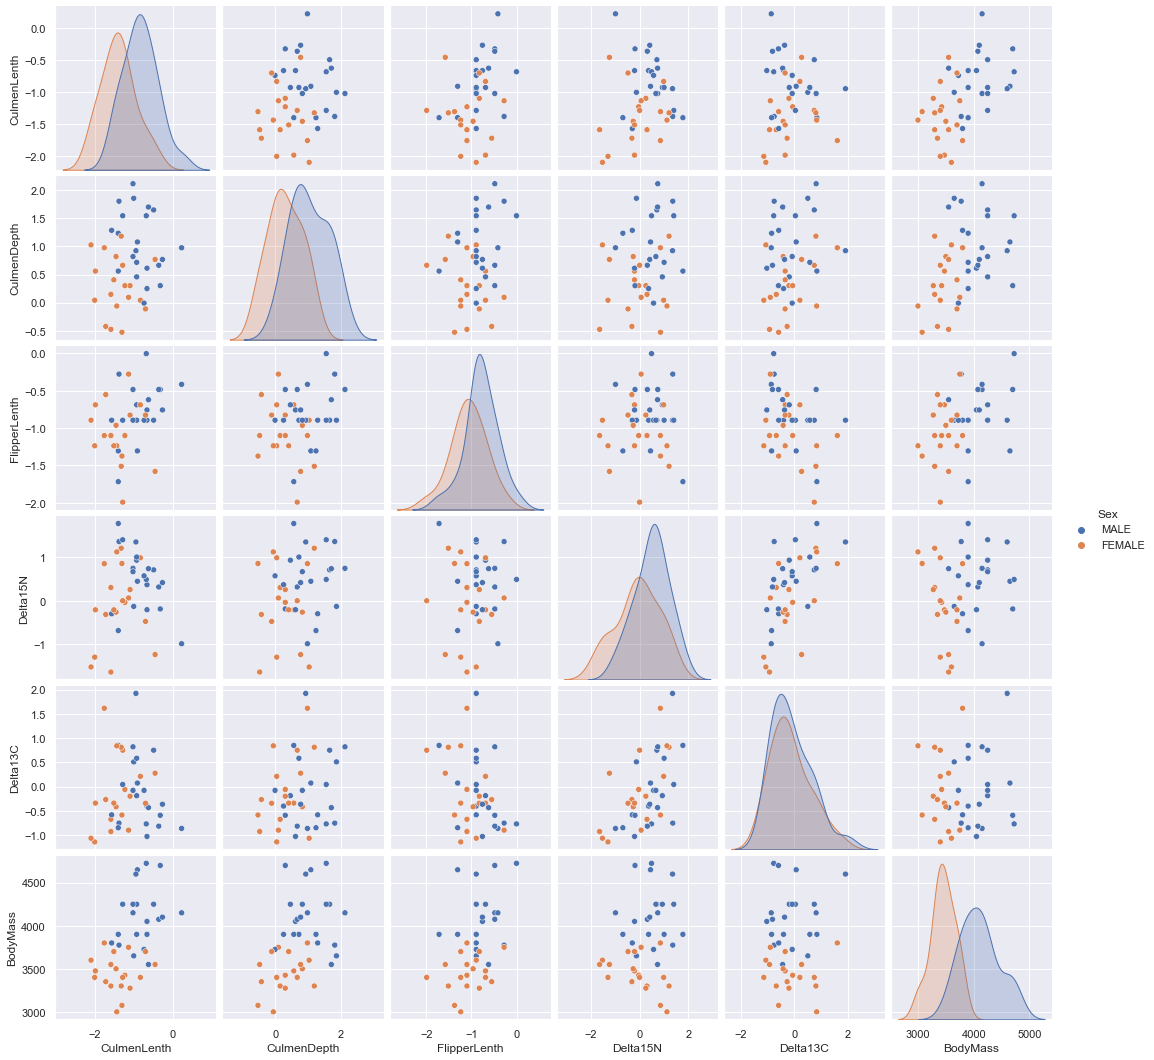

In [40]:
sns.pairplot(pd.concat([train0,train.loc[train['Species']==0, 'BodyMass']], axis=1), hue='Sex')
plt.show()

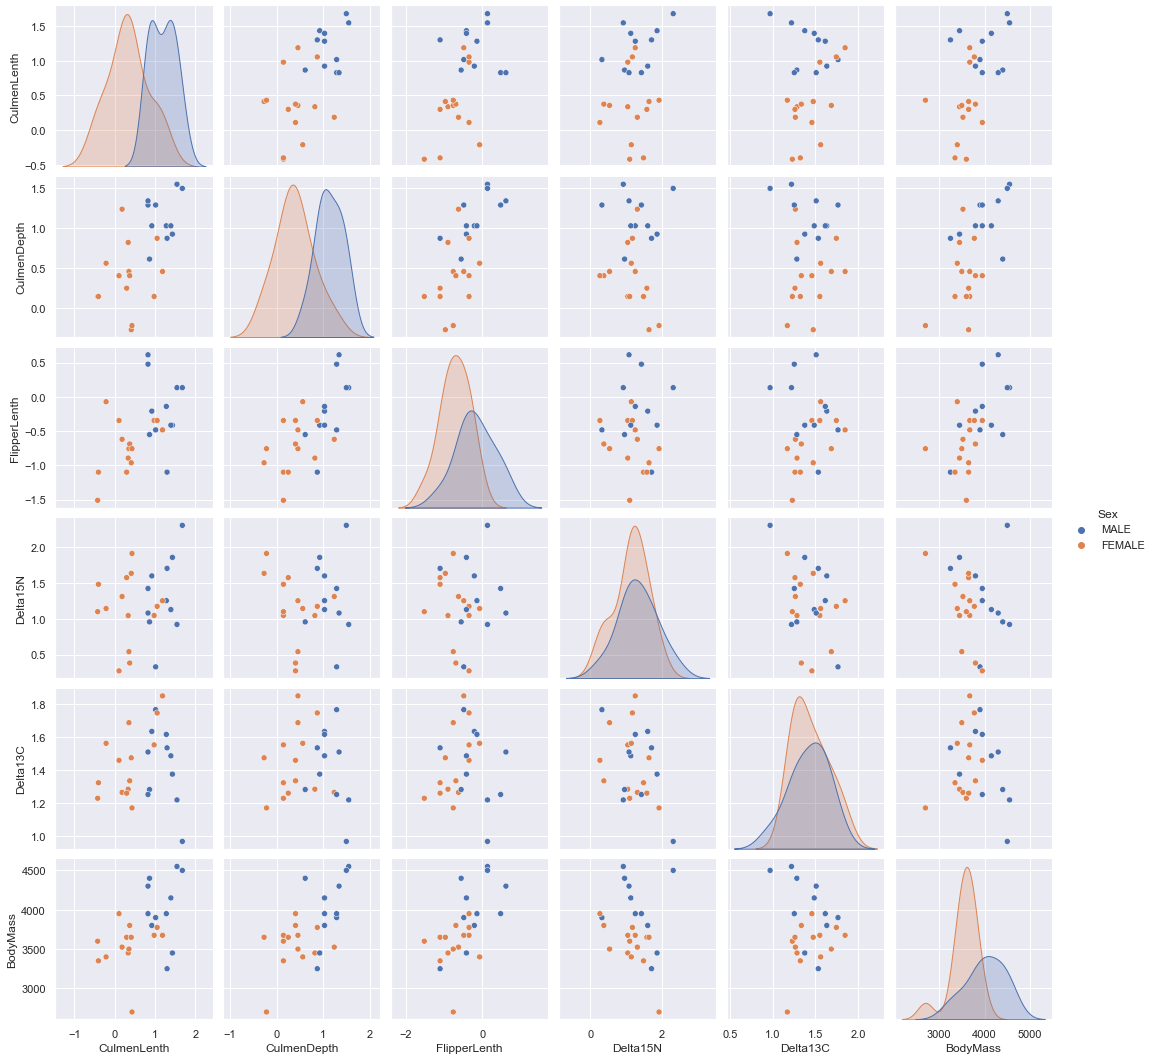

In [41]:
sns.pairplot(pd.concat([train1,train.loc[train['Species']==1, 'BodyMass']], axis=1), hue='Sex')
plt.show()

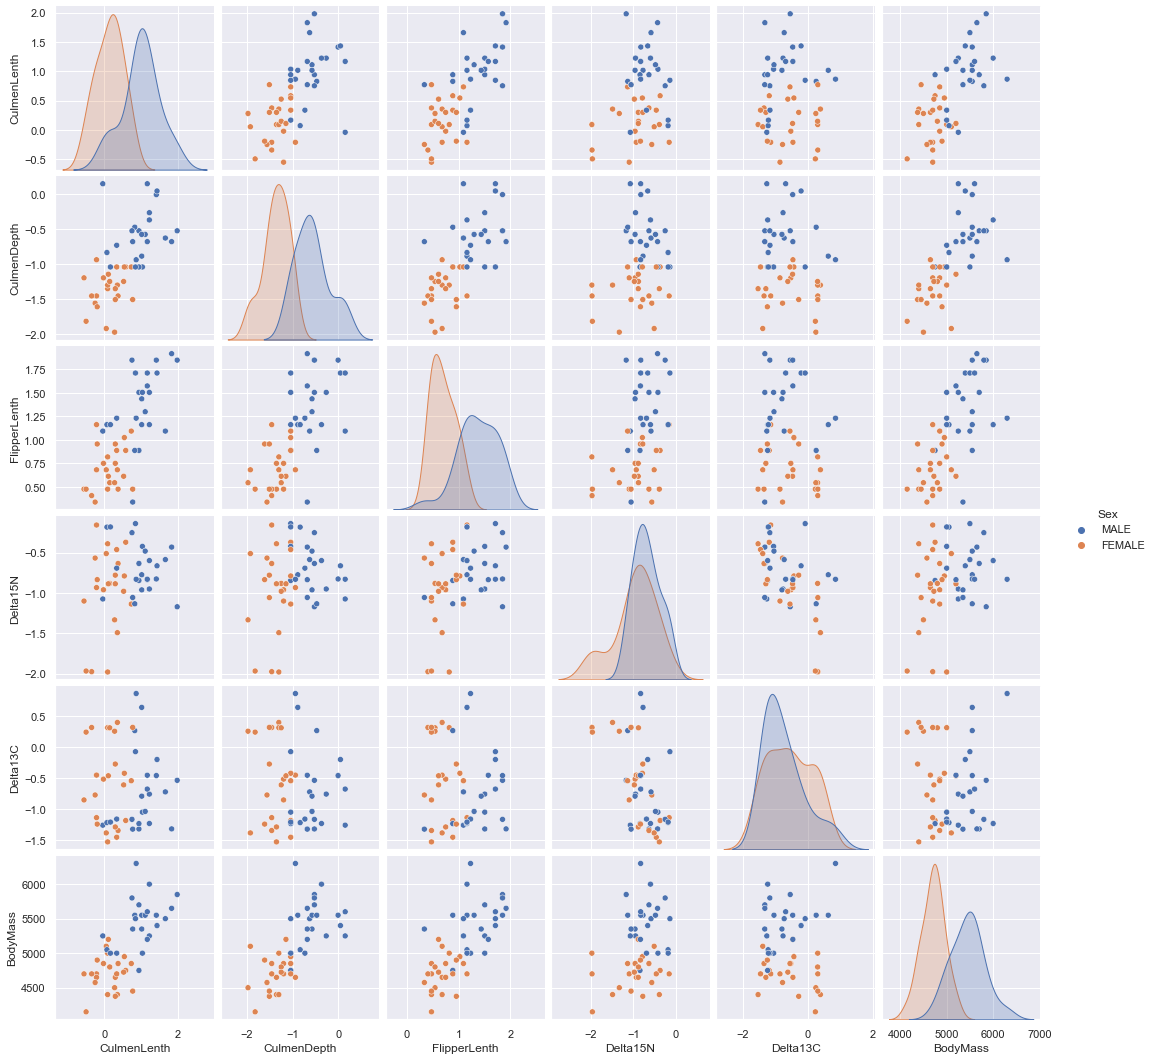

In [42]:
sns.pairplot(pd.concat([train2,train.loc[train['Species']==2, 'BodyMass']], axis=1), hue='Sex')
plt.show()

In [43]:
train0.columns

Index(['CulmenLenth', 'CulmenDepth', 'FlipperLenth', 'Delta15N', 'Delta13C',
       'Sex'],
      dtype='object')

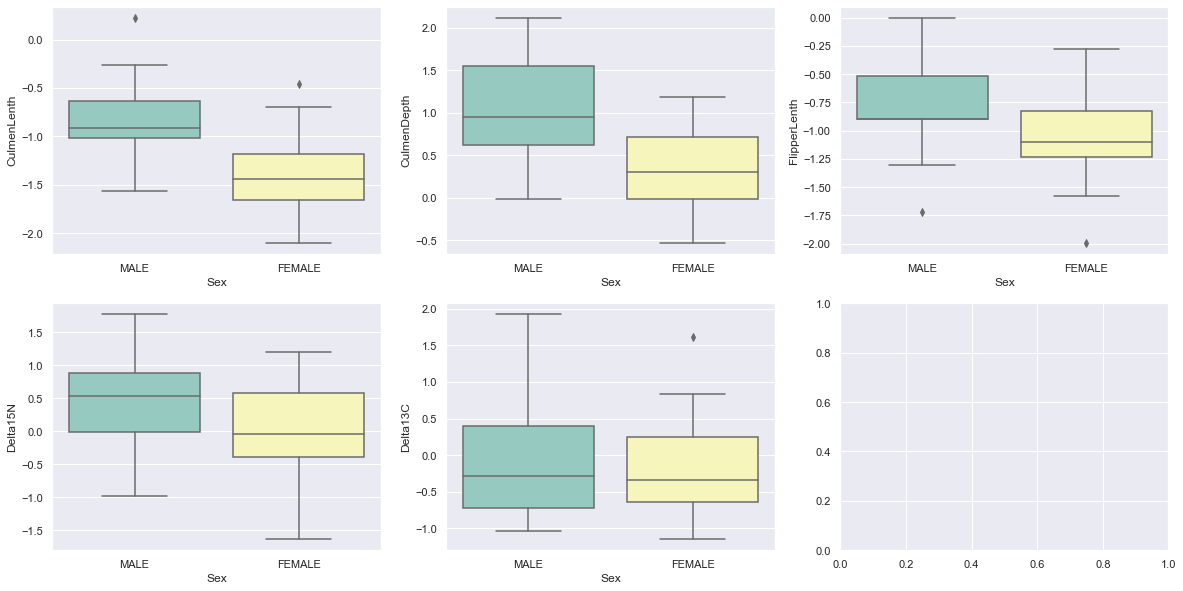

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i, col in enumerate(train0.columns[:-1]):
    sns.boxplot(data=train0, x='Sex', y=col,palette='Set3', ax=ax[i//3][i%3], dodge=False)
plt.show()

In [45]:
print(train0[train0.CulmenLenth>0].index)
print(train0[(train0.CulmenLenth> -0.5) & (train0.Sex=='FEMALE')].index)

print(train0[(train0.FlipperLenth< -1.7)].index)
print(train0[(train0.Delta13C> 1.5) & (train0.Sex=='FEMALE')].index)

Int64Index([50], dtype='int64', name='id')
Int64Index([90], dtype='int64', name='id')
Int64Index([68, 81], dtype='int64', name='id')
Int64Index([44], dtype='int64', name='id')


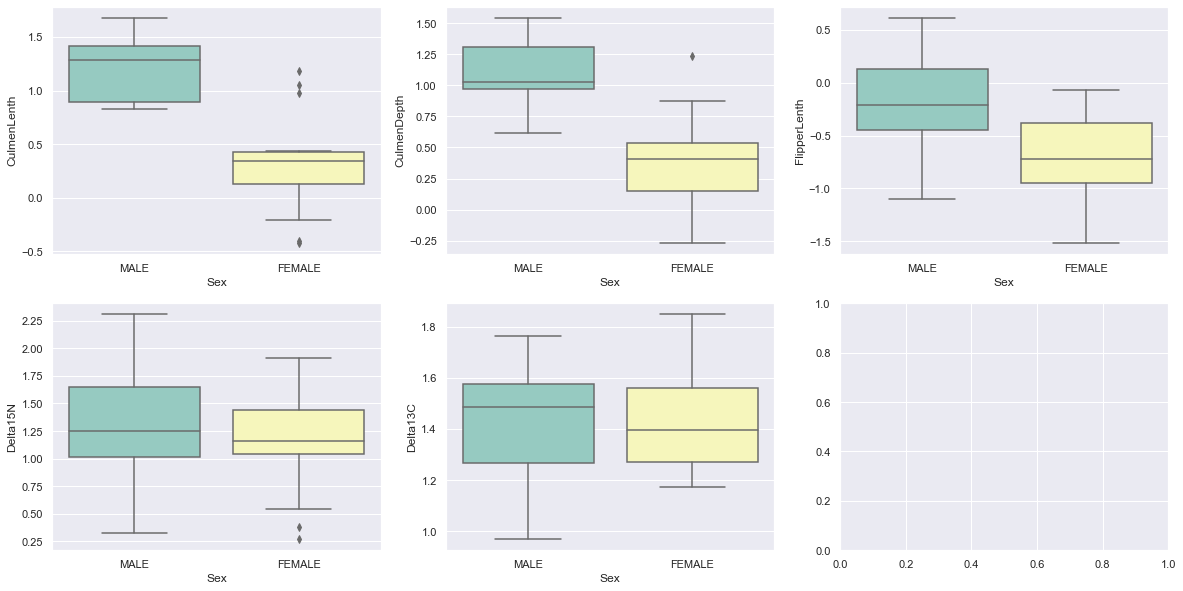

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i, col in enumerate(train1.columns[:-1]):
    sns.boxplot(data=train1, x='Sex', y=col,palette='Set3', ax=ax[i//3][i%3], dodge=False)
plt.show()

In [47]:
print(train1[(train1.CulmenDepth> 1) & (train1.Sex=='FEMALE')].index)
print(train1[(train1.Delta15N< 0.5) & (train1.Sex=='FEMALE')].index)

Int64Index([24], dtype='int64', name='id')
Int64Index([53, 76], dtype='int64', name='id')


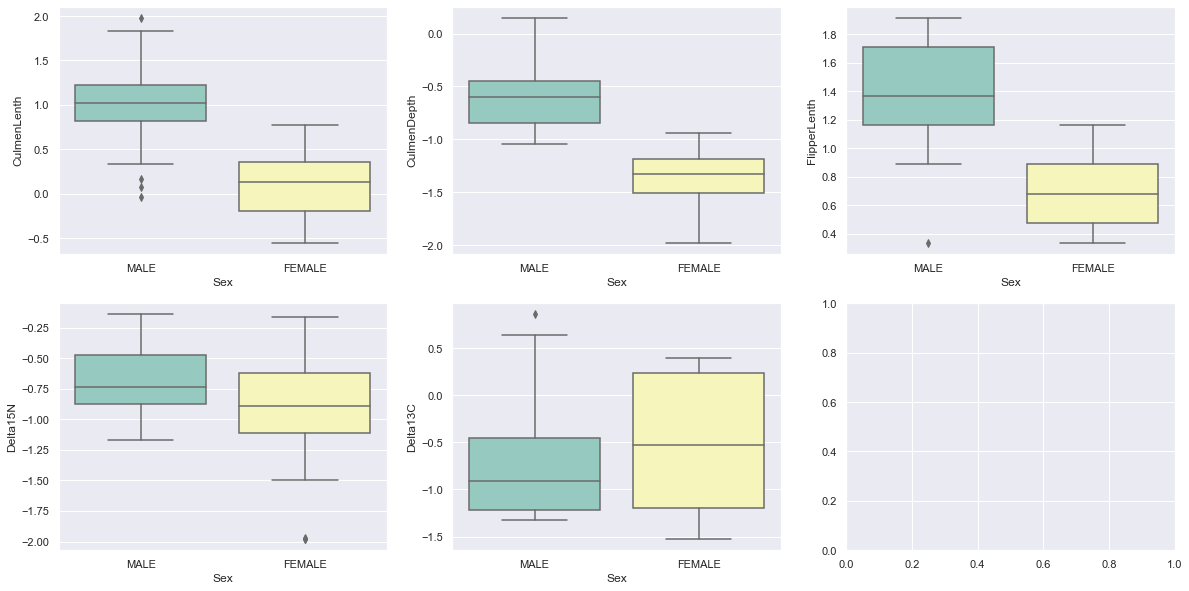

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i, col in enumerate(train2.columns[:-1]):
    sns.boxplot(data=train2, x='Sex', y=col,palette='Set3', ax=ax[i//3][i%3], dodge=False)
plt.show()

In [49]:
print(train2[train2.CulmenLenth>1.9].index)
print(train2[(train2.CulmenLenth< 0.3) & (train2.Sex=='MALE')].index) 

print(train2[(train2.FlipperLenth< 0.4)& (train2.Sex=='MALE')].index)
print(train2[(train2.Delta15N<-1.75)& (train2.Sex=='FEMALE')].index)
print(train2[(train2.Delta13C>.7)].index)

Int64Index([37], dtype='int64', name='id')
Int64Index([40, 95, 106], dtype='int64', name='id')
Int64Index([103], dtype='int64', name='id')
Int64Index([36, 84, 93], dtype='int64', name='id')
Int64Index([67], dtype='int64', name='id')


In [50]:
t = train_dummies.drop([50,90,68,81,44,24,53,76,37,103,67,40, 95, 106,36, 84, 93,68, 81])

In [51]:
model = ols(Rformula, data=t)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BodyMass   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     50.67
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           1.34e-32
Time:                        16:50:40   Log-Likelihood:                -683.16
No. Observations:                  97   AIC:                             1390.
Df Residuals:                      85   BIC:                             1421.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1587.5452     22.051     71.995      0.000    1543.702    1631.388
CulmenLenth             84.6220     85.057      0.995      0.323     -84.494     253.738
CulmenDepth             83.0840     77.337      1.074      0.286     -70.683     236.851
FlipperLenth           183.3700     97.743      1.876      0.064     -10.969     377.709
Delta15N               -58.0300     61.495     -0.944      0.348    -180.299      64.239
Delta13C                 0.1008     59.148      0.002      0.999    -117.502     117.703
Species_0              323.9296    129.634      2.499      0.014      66.182     581.678
Species_1              127.0930    128.935      0.986      0.327    -129.265     383.451
Species_2             1136.5226    162.883      6.978      0.000     812.667    1460.378
Island_Biscoe          577.3294     87.210      6.620      0.000     403.932     750.727
Island_Dream           500.2210     70.652      7.080      0.000     359.745     640.697
Island_Torgersen       509.9948     80.308      6.350      0.000     350.321     669.669
ClutchCompletion_No    825.6501     57.490     14.362      0.000     711.345     939.955
ClutchCompletion_Yes   761.8951     43.139     17.661      0.000     676.124     847.667
Sex_FEMALE             569.0982     54.240     10.492      0.000     461.254     676.942
Sex_MALE              1018.4469     56.854     17.913      0.000     905.406    1131.488
==============================================================================
Omnibus:                        0.190   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.909   Jarque-Bera (JB):                0.027
Skew:                           0.036   Prob(JB):                        0.987
Kurtosis:                       3.039   Cond. No.                     4.80e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.43e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [52]:
(sum((t['BodyMass'] - res.predict(t))**2)/len(t['BodyMass']))**0.5

276.96740300187724

In [53]:
predictions = res.predict(test_dummies)
predictions

id
0      4286.935113
1      5619.124509
2      3602.362180
3      3293.950728
4      3490.997576
          ...     
223    4073.993867
224    4758.410264
225    4675.970737
226    4063.651493
227    4094.486869
Length: 228, dtype: float64

In [54]:
submission['Body Mass (g)'] = predictions
submission

,Body Mass (g)
id,
0,4286.935113
1,5619.124509
2,3602.362180
3,3293.950728
4,3490.997576
...,...
223,4073.993867
224,4758.410264
225,4675.970737


In [55]:
submission.to_csv('./submission6.csv')

# PUBLIC SCORE 276.69595

### 데이터 imbalanced (Species)

In [56]:
res_data = t

In [57]:
res_data.loc[res_data['Species_0']==1, 'Species'] = 0
res_data.loc[res_data['Species_1']==1, 'Species'] = 1
res_data.loc[res_data['Species_2']==1, 'Species'] = 2

In [58]:
res_data.drop(columns=['Species_0', 'Species_1','Species_2'],inplace=True)

In [59]:
x = res_data
y = x.pop('Species')

In [60]:
SEED=42
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(x, y)

In [61]:
res_t = pd.concat([X_res,y_res], axis=1)
res_t

,CulmenLenth,CulmenDepth,FlipperLenth,Delta15N,Delta13C,BodyMass,Island_Biscoe,Island_Dream,Island_Torgersen,ClutchCompletion_No,ClutchCompletion_Yes,Sex_FEMALE,Sex_MALE,Species
0,1.016685,-0.887255,1.161653,-0.774837,0.635810,5550,1,0,0,0,1,0,1,2.0
1,0.922318,1.027037,-0.209242,1.599272,1.633278,3800,0,1,0,1,0,0,1,1.0
2,0.091884,-1.352893,0.476205,-0.390922,-1.526736,4400,1,0,0,0,1,1,0,2.0
3,-0.021357,-1.197680,0.750384,-0.961260,-0.517476,4850,1,0,0,0,1,1,0,2.0
4,0.941191,-0.525091,1.504376,-0.634979,-1.318781,5700,1,0,0,1,0,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.363597,0.161984,-1.084330,1.438181,1.340334,3356,0,1,0,0,0,1,0,1.0
113,0.322773,0.256404,-1.084133,1.566789,1.276060,3650,0,1,0,0,1,1,0,1.0
114,0.562103,-0.001457,-0.819637,1.527485,1.537012,3679,0,1,0,0,1,1,0,1.0
115,0.892933,1.356214,0.569821,1.065694,1.482826,4322,0,1,0,0,1,0,1,1.0


In [62]:
X_res = res_t

In [63]:
X_res['Species_0'] = 0
X_res['Species_1'] = 0
X_res['Species_2'] = 0

X_res.loc[X_res['Species']==0, 'Species_0'] = 1
X_res.loc[X_res['Species']==0, 'Species_1'] = 0
X_res.loc[X_res['Species']==0, 'Species_2'] = 0

X_res.loc[X_res['Species']==1, 'Species_0'] = 0
X_res.loc[X_res['Species']==1, 'Species_1'] = 1
X_res.loc[X_res['Species']==1, 'Species_2'] = 0

X_res.loc[X_res['Species']==2, 'Species_0'] = 0
X_res.loc[X_res['Species']==2, 'Species_1'] = 0
X_res.loc[X_res['Species']==2, 'Species_2'] = 1

X_res.pop('Species')

0      2.0
1      1.0
2      2.0
3      2.0
4      2.0
      ... 
112    1.0
113    1.0
114    1.0
115    1.0
116    1.0
Name: Species, Length: 117, dtype: float64

In [64]:
X_res.columns

Index(['CulmenLenth', 'CulmenDepth', 'FlipperLenth', 'Delta15N', 'Delta13C',
       'BodyMass', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'ClutchCompletion_No', 'ClutchCompletion_Yes', 'Sex_FEMALE', 'Sex_MALE',
       'Species_0', 'Species_1', 'Species_2'],
      dtype='object')

In [65]:
y_res = X_res.pop('BodyMass')

In [66]:
Rformula = 'BodyMass ~' + ' + '.join(X_res.columns)

In [67]:
model = ols(Rformula, data=pd.concat([X_res,y_res],axis=1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BodyMass   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     50.50
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           1.19e-38
Time:                        16:51:55   Log-Likelihood:                -821.30
No. Observations:                 117   AIC:                             1671.
Df Residuals:                     103   BIC:                             1709.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2540.5036    172.444     14.732      0.000    2198.502    2882.505
CulmenLenth             73.4617     78.633      0.934      0.352     -82.489     229.412
CulmenDepth             93.8225     73.027      1.285      0.202     -51.010     238.655
FlipperLenth           159.4144     85.844      1.857      0.066     -10.836     329.665
Delta15N               -53.2735     57.551     -0.926      0.357    -167.412      60.864
Delta13C                -2.3716     56.610     -0.042      0.967    -114.644     109.901
Island_Biscoe         -443.3253    312.214     -1.420      0.159   -1062.528     175.877
Island_Dream          -499.8826    301.224     -1.660      0.100   -1097.289      97.524
Island_Torgersen      -517.4278    305.920     -1.691      0.094   -1124.148      89.293
ClutchCompletion_No     66.0707    130.973      0.504      0.615    -193.683     325.824
ClutchCompletion_Yes    49.1220    111.133      0.442      0.659    -171.284     269.528
Sex_FEMALE            1040.4945     99.842     10.421      0.000     842.482    1238.507
Sex_MALE              1500.0091    101.059     14.843      0.000    1299.583    1700.435
Species_0              592.2322    130.566      4.536      0.000     333.286     851.178
Species_1              460.5502    129.893      3.546      0.001     202.937     718.163
Species_2             1487.7212    165.064      9.013      0.000    1160.356    1815.086
==============================================================================
Omnibus:                        1.884   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.373
Skew:                          -0.225   Prob(JB):                        0.503
Kurtosis:                       3.283   Cond. No.                     1.43e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [68]:
(sum((y_res - res.predict(pd.concat([X_res,y_res],axis=1)))**2)/len(y_res))**0.5

270.60993455588533

[2] The smallest eigenvalue is 8.65e-31. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.
## 다중공선성 - 일부 feature 제외

In [69]:
Rformula = 'BodyMass ~ CulmenLenth + CulmenDepth + FlipperLenth + Delta15N + Delta13C + Species_1 + Species_2 +Island_Dream + Island_Biscoe + Island_Torgersen+ClutchCompletion_Yes + Sex_FEMALE'

In [70]:
Rformula

'BodyMass ~ CulmenLenth + CulmenDepth + FlipperLenth + Delta15N + Delta13C + Species_1 + Species_2 +Island_Dream + Island_Biscoe + Island_Torgersen+ClutchCompletion_Yes + Sex_FEMALE'

In [71]:
model = ols(Rformula, data=pd.concat([X_res,y_res],axis=1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BodyMass   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     55.08
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           1.77e-39
Time:                        16:52:21   Log-Likelihood:                -821.44
No. Observations:                 117   AIC:                             1669.
Df Residuals:                     104   BIC:                             1705.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4669.4571    323.086     14.453      0.000    4028.765    5310.149
CulmenLenth             77.1976     78.003      0.990      0.325     -77.485     231.880
CulmenDepth             98.2186     72.245      1.360      0.177     -45.046     241.484
FlipperLenth           153.6077     84.763      1.812      0.073     -14.480     321.696
Delta15N               -54.5878     57.285     -0.953      0.343    -168.186      59.011
Delta13C                -1.2249     56.361     -0.022      0.983    -112.991     110.541
Species_1             -142.1075    176.707     -0.804      0.423    -492.525     208.310
Species_2              905.1460    247.035      3.664      0.000     415.267    1395.025
Island_Dream          -499.7000    300.142     -1.665      0.099   -1094.893      95.493
Island_Biscoe         -442.2209    311.085     -1.422      0.158   -1059.114     174.672
Island_Torgersen      -519.4950    304.794     -1.704      0.091   -1123.913      84.924
ClutchCompletion_Yes     9.0486     77.439      0.117      0.907    -144.517     162.614
Sex_FEMALE            -456.1033    102.489     -4.450      0.000    -659.343    -252.863
==============================================================================
Omnibus:                        1.792   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.279
Skew:                          -0.206   Prob(JB):                        0.528
Kurtosis:                       3.304   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
(sum((y_res - res.predict(pd.concat([X_res,y_res],axis=1)))**2)/len(y_res))**0.5

270.94402503080386

In [73]:
predictions = res.predict(test_dummies)
predictions

id
0      4335.404335
1      5610.346223
2      3629.318006
3      3353.200231
4      3460.734501
          ...     
223    4136.937706
224    4763.320633
225    4679.364446
226    4126.348689
227    4108.794798
Length: 228, dtype: float64